# Reddit Stream

### Import libraries

In [2]:
from utils import reddit_utils, plot_utils, sentiment_utils

In [1]:
import praw
import nltk
import pandas as pd
import pyLDAvis
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from dotenv import load_dotenv

### Create Reddit instance

In [2]:
load_dotenv(dotenv_path="credentials/credentials.env")

reddit = praw.Reddit(
    client_id=os.getenv("CLIENT_ID"),
    client_secret= os.getenv("CLIENT_SECRET"),
    username=os.getenv("USERNAME"),
    password=os.getenv("PASSWORD"),
    user_agent="analyze_comments"
)

### Read and save subreddit comments

In [10]:
subreddit = "AskReddit"
duration_stream = 60*60*2 # seconds

In [11]:
reddit_df = reddit_utils.stream_comments_to_dataframe(reddit, subreddit, duration_stream)

Start streaming from r/AskReddit...
Stop streaming!


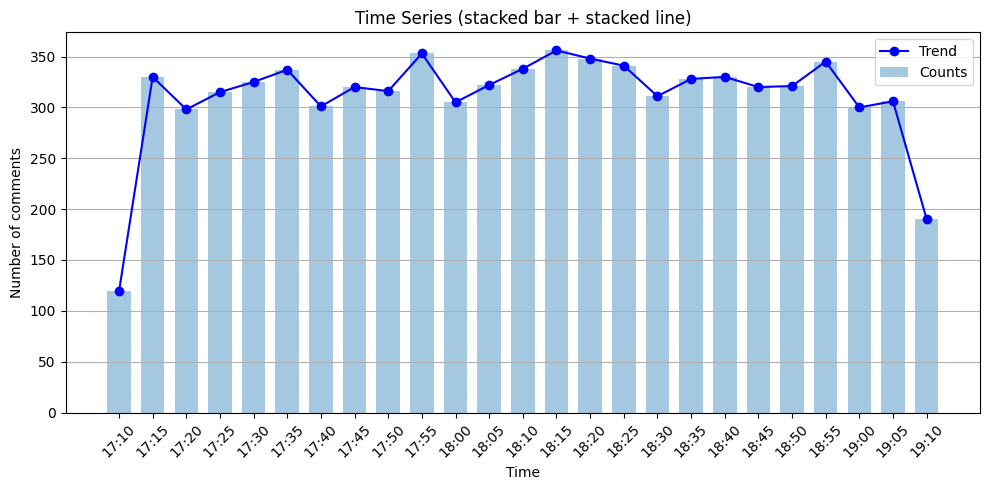

In [21]:
plot_utils.plot_time_series(reddit_df["datetime"], interval_minutes=5, figsize=(10,5), ylabel="Number of comments")

In [ ]:
reddit_df.to_csv("reddit.csv", index=False)

### Preprocessing

In [5]:
reddit_df = pd.read_csv("reddit.csv")

In [8]:
# if there are nan, replace with empty string
reddit_df.loc[reddit_df["text"].isna(), "text"] = ""

### Task 01: Sentiment Trend (NLTK + VADER)

In [9]:
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon')

In [10]:
reddit_df = sentiment_utils.apply_sentiment(reddit_df, "text")

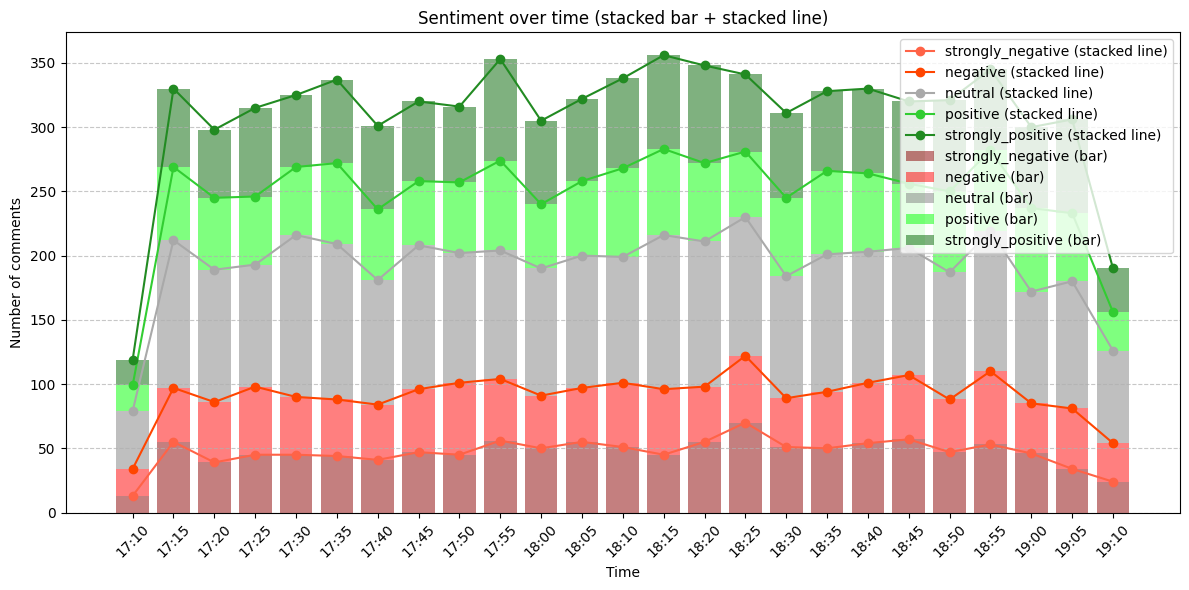

In [11]:
plot_utils.plot_sentiment_over_time(reddit_df, interval_minutes=5, figsize=(12,6), ylabel="Number of comments", has_legend=True)

### Task 02: Word Cloud Visualization

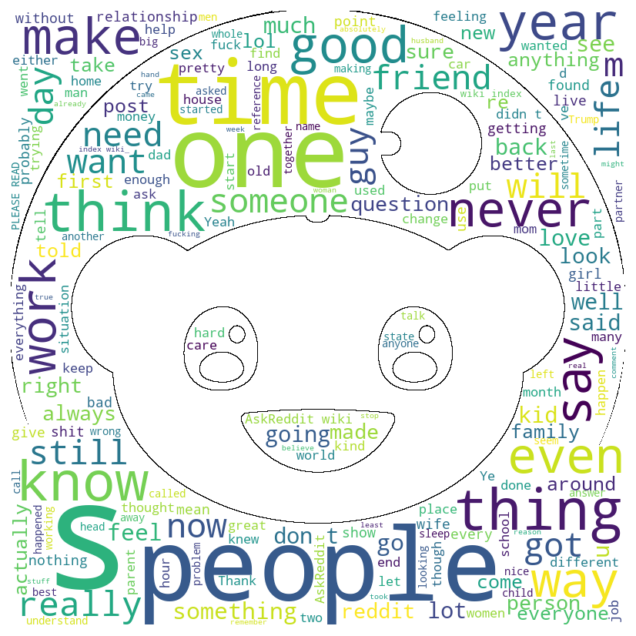

In [12]:
full_text = " ".join(reddit_df["text"])
url_pic = "https://redditinc.com/hs-fs/hubfs/Reddit%20Inc/Content/Brand%20Page/Reddit_Logo.png?width=800&height=800&name=Reddit_Logo.png"
plot_utils.plot_wordcloud(url_pic, full_text)

### Task 03: Topic Modelling

In [ ]:
tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
reddit_values = reddit_df["text"].values
X = tfidf.fit_transform(reddit_values)

(7775, 5000)

In [ ]:
lda = LDA(n_components=10, max_iter=10, verbose=True)
lda.fit_transform(X)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


array([[0.01917265, 0.54008149, 0.01918032, ..., 0.30651294, 0.01917285,
        0.01917644],
       [0.027761  , 0.75008573, 0.02778599, ..., 0.027772  , 0.02776093,
        0.02776845],
       [0.04195361, 0.04195103, 0.04194904, ..., 0.04195388, 0.04195284,
        0.62241568],
       ...,
       [0.02200582, 0.02204451, 0.02201932, ..., 0.02200441, 0.80188248,
        0.02200402],
       [0.02780104, 0.02780158, 0.02779983, ..., 0.02780969, 0.02780325,
        0.02780411],
       [0.05      , 0.5499543 , 0.05000029, ..., 0.05000366, 0.05000712,
        0.05001118]], shape=(7775, 10))

In [15]:
n_words = 10

for index, topic in enumerate(lda.components_):
    print("\nTOPIC %d - %d most popular words" % (index+1, n_words))
    top_indices = topic.argsort()[-n_words:][::-1]
    print([tfidf.get_feature_names_out()[i] for i in top_indices])


TOPIC 1 - 10 most popular words
['really', 'like', 'guess', 'know', 'baby', 'cat', 'straight', 'women', 'free', 'don']

TOPIC 2 - 10 most popular words
['time', 'life', 'like', 'friend', 'just', 'nice', 'night', 'doing', 'lmao', 'day']

TOPIC 3 - 10 most popular words
['sorry', 'comment', 'mean', 'haha', 'make', 'does', 'drugs', 'don', 'like', 'dick']

TOPIC 4 - 10 most popular words
['lol', 'remember', 'states', 'president', 'cheating', 'social', 'people', 'anxiety', 'just', 'like']

TOPIC 5 - 10 most popular words
['fuck', 'thanks', 'family', 'great', 'dog', 'pretty', 'oh', 'like', 'good', 'mind']

TOPIC 6 - 10 most popular words
['good', 'yes', 'wife', 'hope', 'just', 'mom', 'don', 'right', 'definitely', 'sleep']

TOPIC 7 - 10 most popular words
['post', 'askreddit', 'reddit', 'com', 'question', 'www', 'https', 'questions', 'wiki', 'message']

TOPIC 8 - 10 most popular words
['people', 'just', 'think', 'don', 'like', 'way', 'know', 'years', 'things', 'did']

TOPIC 9 - 10 most popul

In [ ]:
lda_viz = pyLDAvis.lda_model.prepare(lda, X, tfidf, n_jobs=1) # only 1 core, no parallelization
pyLDAvis.save_html(lda_viz, "output/lda_visualization.html")
pyLDAvis.display(lda_viz)

Check the output here: [lda_visualization.html](https://thedanicode24.github.io/reddit-stream/output/lda_visualization.html)